# Evaluating Model

## Extrapolation: Estimate higher wt (>25%)

Training data only input up to 25% wt% of filler. The unknown range from 25 to 50% is extrapolated in this session.

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler, StandardScaler
# FUNCTIONS
from functions import *

## Import data

In [2]:
filename_alldata = "data-evaluation/HDPE_SWCNT_data-set-8.csv"
alldata = pd.read_csv(filename_alldata, index_col=None, header=0)
# Drop columns which are not used for now
alldata_clean = alldata.drop(['polymer_p2', 'ratio_1_2','filler_2','wt_l2','owner','foaming'], axis=1)  # , inplace=True
alldata_clean = mapStringToNum(alldata_clean)
alldata_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,0,1,26.818297,708.533755
1,0,1,25.749656,652.784933
2,0,1,1.045467,0.714814
3,0,1,14.253655,197.505216
4,0,1,16.579815,268.298345


## Loading saved data

Loading saved model and scalers

In [3]:
model = tf.keras.models.load_model('saved/predictor-conductivity-model')

from pickle import load
X_scaler = load(open('saved/X_scaler.pkl', 'rb'))
Y_scaler = load(open('saved/Y_scaler.pkl', 'rb'))

# Extrapolation: Estimate higher wt (>25%)

In [4]:
filename_unknowndata7 = "data-evaluation/HDPE_SWCNT_data-set-7.csv"
unknowndata7 = pd.read_csv(filename_unknowndata7, index_col=None, header=0)
#alldata['labels'] = alldata['polymer_1'] + "-" + alldata['filler_1']
unknowndata7.drop(['polymer_p2', 'ratio_1_2','filler_2','wt_l2','owner','foaming'], axis=1, inplace=True)   #,'foaming'
unknowndata7_clean = unknowndata7.copy()
unknowndata7_clean = mapStringToNum(unknowndata7_clean)
#unknowndata7_clean.head()

In [5]:
# Pull out columns for X (data to train with) and Y (value to predict)
X_unknowndata7 = unknowndata7_clean.drop('conductivity', axis=1).values
X_scaled_unknowndata7 = X_scaler.transform(X_unknowndata7)
# Calculate predictions
PredValSet_unknowndata7 = model.predict(X_scaled_unknowndata7)
PredValSet_unknowndata72 = Y_scaler.inverse_transform(PredValSet_unknowndata7)

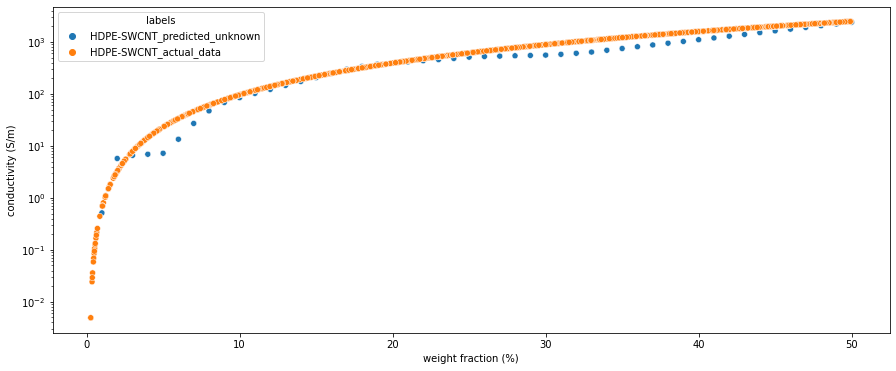

In [6]:
compdata = unknowndata7.copy()
compdata['labels']    = compdata['polymer_1'] + "-" + compdata['filler_1'] + "_predicted_unknown"
compdata['conductivity'] = PredValSet_unknowndata72

alldata['labels']    = alldata['polymer_1'] + "-" + alldata['filler_1'] + "_actual_data"
compdata = compdata.append(alldata, ignore_index = True)

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
g = sns.scatterplot(data=compdata ,x="wt_l1", y ="conductivity", hue="labels" , ax = ax ,markers=["-","x"] );

# Conclusion

## Results are acceptable
The difference between prediction and experiment is within one order of magnitude, which is acceptable.

## Issues
There are a strange behaviour at range around 5%. 

However, our data (conductivity) of different fillers is highly divergent. The carbon nanotube has much higher in intrisic conductivity, leading CNT-based composite has much higher electrical conductivity than the GNP one. 